In [1]:
data_dir = "C:/Users/fents/Documents/data_experiment"
window_size = 250
step_size = 50

# import general classes for data processing
import ruptures as rpt
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd 
import numpy as np
import seaborn as sns
import json

from sklearn.metrics import accuracy_score
from sklearn.preprocessing import LabelEncoder
from imblearn.under_sampling import RandomUnderSampler
from sklearn.metrics import confusion_matrix
from tqdm import tqdm 
from glob import glob 
from pathlib import PureWindowsPath

# import our custom classes
import sys
path_to_directory = '../'
if path_to_directory not in sys.path:
    sys.path.append(path_to_directory)
from model import Signal, GestureRecognitionModel
from model import GestureRecognitionDataset

# import MLP
from sklearn.neural_network import MLPClassifier

# import for loop and XGboost
from tqdm.notebook import tqdm
from xgboost import XGBClassifier

# import model saving
import joblib

def parse_ossur_sensor_recording(fpath):
    with open(fpath) as f:
        data = json.load(f)
    emg_shape = min(len(data['1264']['value1']), len(data['1265']['value1'])), 4
    emg = np.zeros(emg_shape)
    emg[:,0] = data['1264']['value1'][:emg_shape[0]] 
    emg[:,1] = data['1264']['value2'][:emg_shape[0]]
    emg[:,2] = data['1265']['value1'][:emg_shape[0]]
    emg[:,3] = data['1265']['value2'][:emg_shape[0]]

    disp_shape = min(len(data['528']['value1']), len(data['529']['value1'])), 4
    disp = np.zeros(disp_shape)
    disp[:,0] = data['528']['value1'][:disp_shape[0]]
    disp[:,1] = data['528']['value2'][:disp_shape[0]]
    disp[:,2] = data['529']['value1'][:disp_shape[0]]
    disp[:,3] = data['529']['value2'][:disp_shape[0]]

    return emg, disp

def resample(signal, n):
    # Initialize the array to hold the resampled signal
    resampled_signal_2d = np.zeros((n, signal.shape[1]))
    
    # New sample points for resampling
    new_positions = np.linspace(0, 1, n, endpoint=False)
    
    # Original positions corresponding to the existing samples
    original_positions = np.linspace(0, 1, signal.shape[0], endpoint=False)
    
    # Apply resampling for each row
    for i in range(signal.shape[1]):
        resampled_signal_2d[:, i] = np.interp(new_positions, original_positions, signal[:,i])
    
    return resampled_signal_2d

class Signal():
    def __init__(self, path_to_file=None, signal=None, step=10, window_size = 50):
        """
        Args:
        path_to_file (str): path to file containing numpy array for the signal
        signal (np.array): numpy array containing the signal
        Both arguments are optional. 
        This class can be instantiated to just use the functions.
        """
        if path_to_file:
            self.signal = np.load(path_to_file)
            
        else:
            if len(np.array(signal).shape) == 1:
                self.signal = np.expand_dims(np.array(signal), axis =1)
            else: 
                self.signal = np.array(signal)

        self.n_samples = self.signal.shape[0]
        self.step = step
        self.window_size = window_size
        if self.n_samples < 50:
            raise Exception ("signal too short! minimum size = 50 samples")
    
        self.features = {"mav":self.mav, "rms":self.rms, "ssc":self.ssc, "wl":self.wl, "var":self.var, 
                         "iasd":self.iasd, "iatd":self.iatd}
        self.n_features = self.signal.shape[1]*len(self.features)
        
    def get_features(self, list_features = "all", remove_transition=False):
        if remove_transition:
            self.remove_transition()
        features = np.empty((0, self.n_features))
        for idx in range(0, self.n_samples-self.window_size, self.step):
            x = self.signal[idx:idx+self.window_size, :]
            features = np.concatenate((features, self.get_features_window(x, list_features)))
        return features
    
    def get_features_window(self, x, list_features="all"):
        features = np.empty((1, 0))
        for f in self.features.values():
            features = np.concatenate((features, f(x).reshape(1, x.shape[1])), axis=1)
        return features

    def remove_transition(self):
        # detection using the mean  
        s = self.get_features(list_features=["mav"]).sum(axis=1)
        trans_idx = 0
        for i in range(0, len(s)-window_size):
            window = s[i:i+window_size]
            if (np.mean(window) > np.mean(s)) :
                break
            trans_idx+=1
        trans_idx = trans_idx*self.step
        self.signal = self.signal[trans_idx:, :]
        self.n_samples = self.signal.shape[0]
    

    # ops 
    def mav(self, x):                                      # mean absolute value
        return sum(abs(x)) / x.shape[0]

    def rms(self, x):                                      # root mean square
        return ((sum(x ** 2)) / x.shape[0]) ** (1 / 2)

    def wl (self, x):                                      # waveform length
        return sum(abs(x[:-1] - x[1:]))

    def ssc(self, x, delta = 1):                           # slope of sign change
        f = lambda x: (x >= delta).astype(float)
        return sum(f(-(x[1:-1, :] - x[:-2, :])*(x[1:-1] - x[2:])))
    
    def var(self, x):                                      # variance
        return sum((x ** 2)) / (x.shape[0] - 1)
    
    def derivative(self, x):
        return x[1:] - x[:-1]
    
    def iasd(self, x):                                     # integrated absolute of second derivative
        return (sum(abs(self.derivative(self.derivative(x)))))
    
    def iatd(self, x):                                     # integrated absolute of third derivative
        return (sum(abs(self.derivative(self.derivative(self.derivative(x))))))
    
    def sliding_avg(self, x, w=1):                         # sliding average with window size w
        return np.convolve(x, np.ones(w), 'valid') / w
    
    def sliding_var(self, x, w=1):
        return bn.move_var(x, window=w)
    
    #vis    
    def display(self, attr = "energy", w = 5):
        plt.figure()
        """
        w (window size) only applicable for functions of energy
        """
        if attr == "energy":
            energy = self.get_features(list_features=["mav"])
            energy = energy.sum(axis = 1)
            plt.plot(energy)
            plt.xlabel("time (samples)")
            plt.ylabel("Energy")
        if attr == "avg_slope_energy":
            energy = self.get_features(list_features=["mav"])
            energy = energy.sum(axis = 1)
            slope = energy[1:] - energy[:-1]
            avg_slope = self.sliding_avg(slope, w)
            plt.plot(avg_slope)
            plt.xlabel("time (samples)")
            plt.ylabel(f"Avg. slope (window = {w})")
        if attr == "sliding_var_energy":
            energy = self.get_features(list_features=["mav"])
            energy = energy.sum(axis = 1)
            mov_var = bn.move_var(energy, window=w)
            mov_avg = bn.move_mean(energy, window=w)
            plt.plot(mov_var/mov_avg)
            plt.xlabel("time (samples)")
            plt.ylabel(f"Moving Variance of Energy (window = {w})")
        ylim_bottom = min(0, plt.gca().get_ylim()[0])
        plt.gca().set_ylim(bottom=ylim_bottom)

  0%|          | 0/180 [00:00<?, ?it/s]

  0%|          | 0/183 [00:00<?, ?it/s]

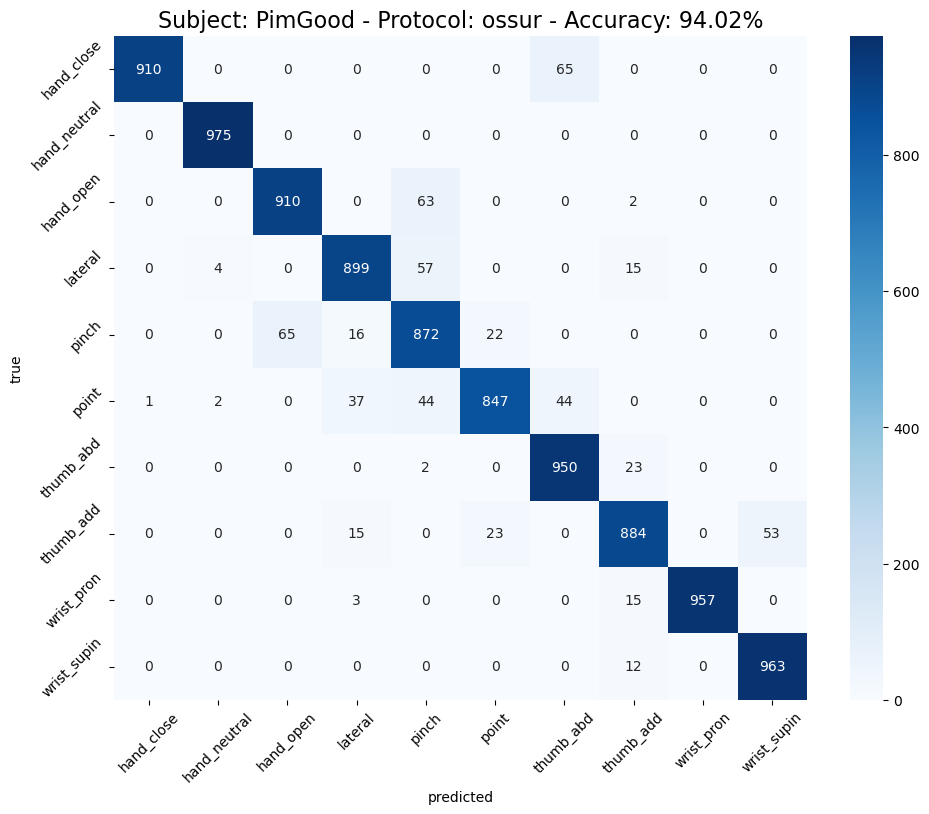

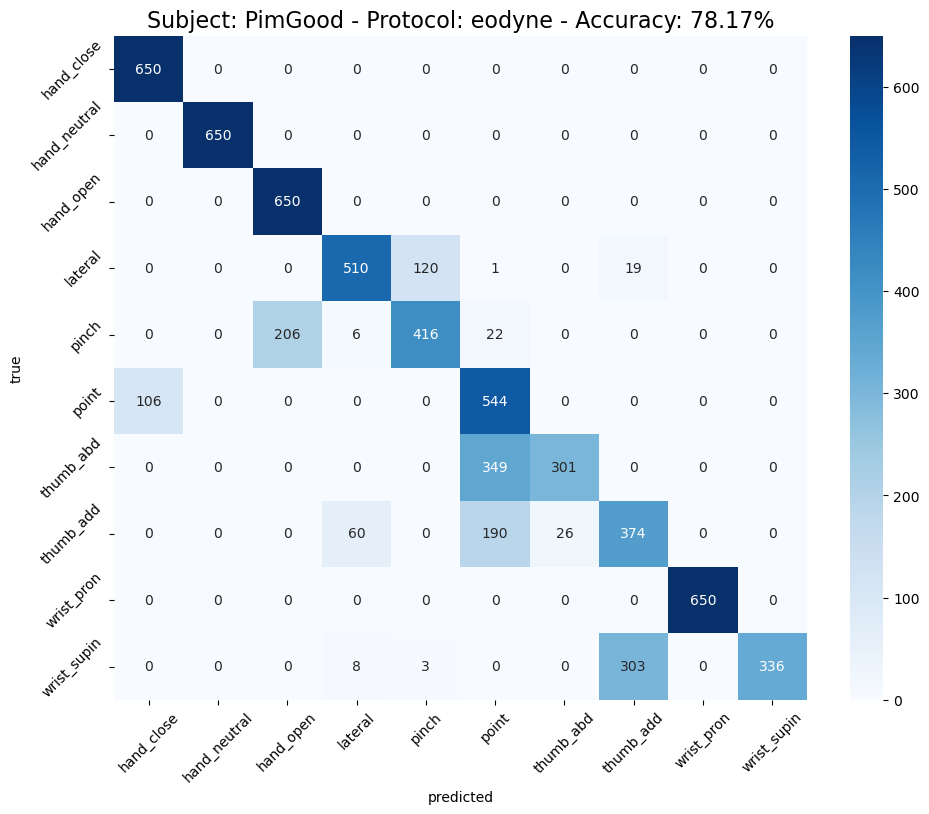

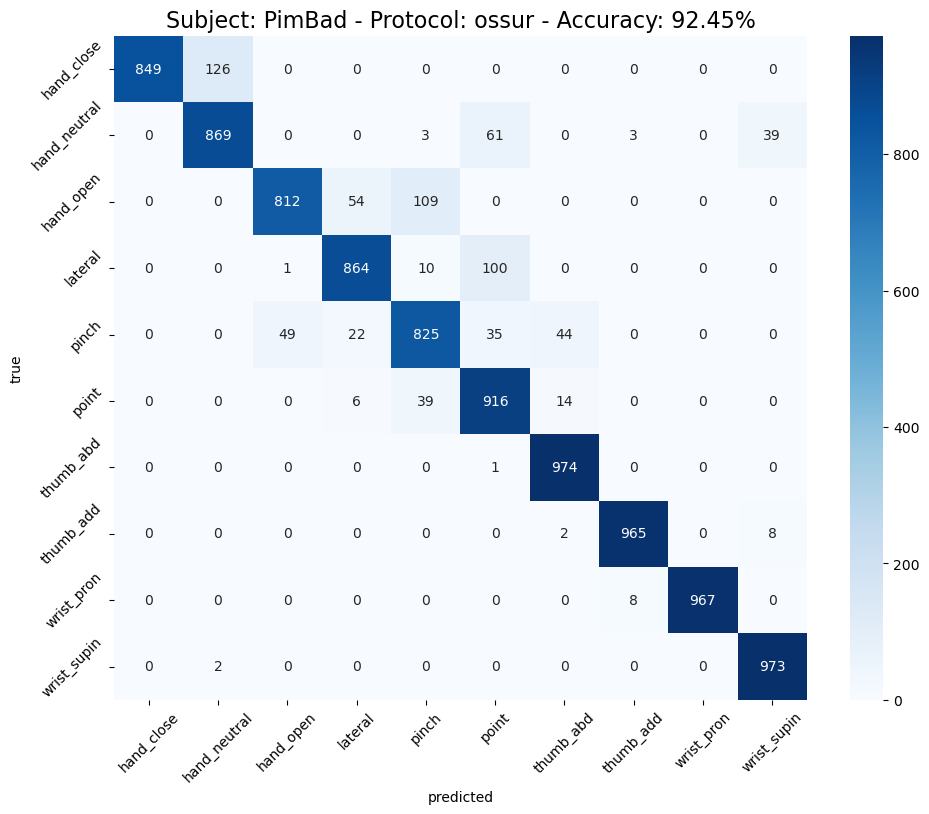

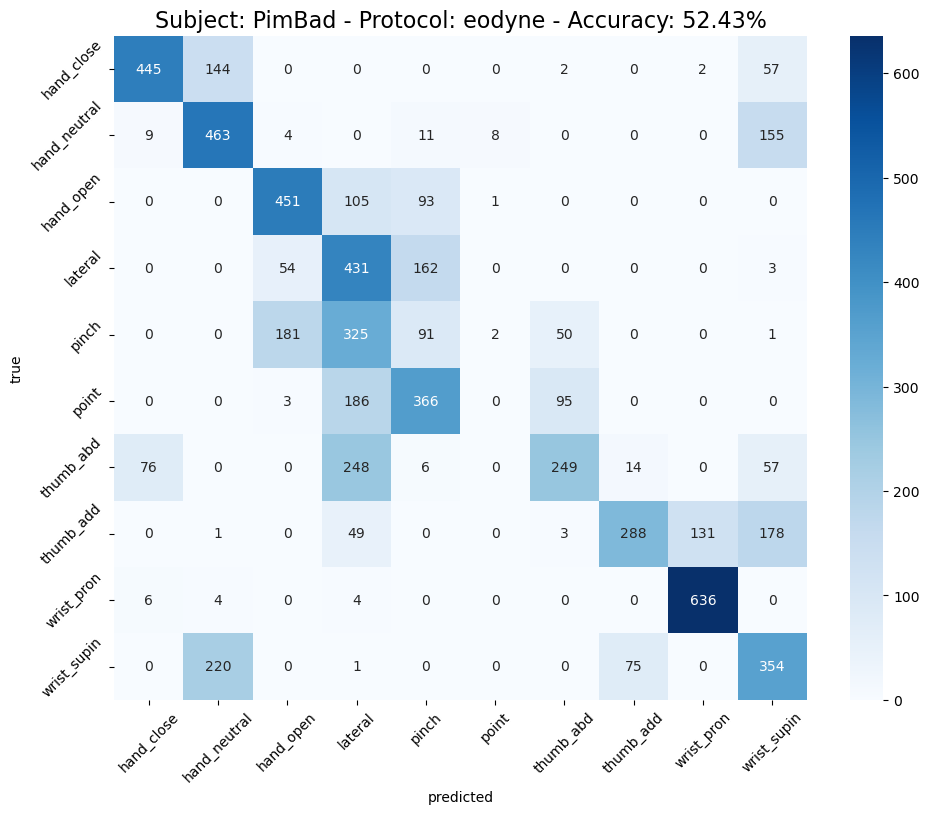

In [2]:
data_dir = "C:/Users/fents/Documents/data_experiment"

gestures_to_use = ["hand_close", "hand_neutral", "hand_open", 
                    "wrist_supin", "wrist_pron","thumb_abd", "thumb_add", "pinch", "lateral", "point"] 


protocols = ["ossur", "eodyne"]
subjects = ["PimGood", "PimBad"]

for subject in subjects:
    files = glob(f"{data_dir}/{subject}*/*.npy")
    df = None
    for fpath in tqdm(files):

        win_fpath = PureWindowsPath(fpath)
        subject = win_fpath.parts[-2][:-1]
        take = win_fpath.parts[-2][-1]
        
        gesture = win_fpath.stem[:-20]
        timestamp = win_fpath.stem[-19:]
        
        emg, disp = parse_ossur_sensor_recording(fpath)
        emg = Signal(signal = emg, window_size=window_size, step=step_size)

        emg_features = emg.get_features()
        disp_features = resample(disp, emg_features.shape[0])
        features = np.concatenate([emg_features, disp_features], axis=1)

        if df is None:
            columns = []
            for feat in emg.features.keys():
                columns.extend([f"{feat}_{idx}" for idx in range(4)])
            
            columns.extend(["disp1","disp2", "disp3", "disp4", "gesture", "subject", "take"])
            df=pd.DataFrame(columns=columns)
        
        temp_df = pd.DataFrame(features, columns = columns[:-3])
        temp_df["gesture"] = [gesture]*temp_df.shape[0]

        
        temp_df["timestamp"] = [timestamp]*temp_df.shape[0]

        temp_df["subject"] = [subject]*temp_df.shape[0]
        temp_df["take"] = [take]*temp_df.shape[0]

        df = pd.concat([df, temp_df], ignore_index=True)

    ds= GestureRecognitionDataset(data_dir)
    df = ds.timestamp_to_iter(df)
    for protocol in protocols:
        accuracies = []
        preds = []
        ys=[]
        df = df[df.gesture.isin(gestures_to_use)]
        gestures = df.gesture.unique()
        gesture_to_int = {gesture:i for i, gesture in enumerate(gestures)}
        int_to_gesture = {val:key for key, val in gesture_to_int.items()}

        if protocol == "ossur":
            for i in range(1,6):
                df_train = df[df["iteration"] != i]
                df_test = df[df["iteration"] == i]
                model = GestureRecognitionModel()
                features_to_keep = df_train.columns[:-4]
                X_train, y_train = df_train[features_to_keep], [gesture_to_int[gesture] for gesture in df_train.gesture]
                X_test, y_test = df_test[features_to_keep], [gesture_to_int[gesture] for gesture in df_test.gesture]
                rus = RandomUnderSampler()
                X_test, y_test = rus.fit_resample(X_test, y_test)
                model.train(X_train, y_train)
                accuracies.append(model.evaluate(X_test, y_test))
                preds.extend(model.predict(X_test))
                ys.extend(y_test)


        if protocol == "eodyne":
            for i in range(1,3):
                df_train = df[df["take"] != str(i)]
                df_test = df[df["take"] == str(i)]
                model = GestureRecognitionModel()
                features_to_keep = df_train.columns[:-4]
                X_train, y_train = df_train[features_to_keep], [gesture_to_int[gesture] for gesture in df_train.gesture]
                X_test, y_test = df_test[features_to_keep], [gesture_to_int[gesture] for gesture in df_test.gesture]
                rus = RandomUnderSampler()
                X_test, y_test = rus.fit_resample(X_test, y_test)
                model.train(X_train, y_train)
                accuracies.append(model.evaluate(X_test, y_test))
                preds.extend(model.predict(X_test))
                ys.extend(y_test)

        cf_matrix = confusion_matrix(ys, preds)
        fig = plt.figure(figsize = (10, 8))
        sns.heatmap(cf_matrix, cmap='Blues', annot=True, fmt=".0f")
        plt.yticks(np.arange(0.5,len(int_to_gesture), 1), [int_to_gesture[i] for i in range(len(int_to_gesture))], rotation=45)
        plt.xticks(np.arange(0.5,len(int_to_gesture), 1), [int_to_gesture[i] for i in range(len(int_to_gesture))], rotation=45)
        plt.ylabel("true")
        plt.xlabel("predicted")
        plt.tight_layout()
        plt.title(f"Subject: {subject} - Protocol: {protocol} - Accuracy: {np.mean(accuracies)*100:.2f}%", fontdict={'fontsize': 16, 'fontweight': 'medium'})

  0%|          | 0/180 [00:00<?, ?it/s]

  0%|          | 0/183 [00:00<?, ?it/s]

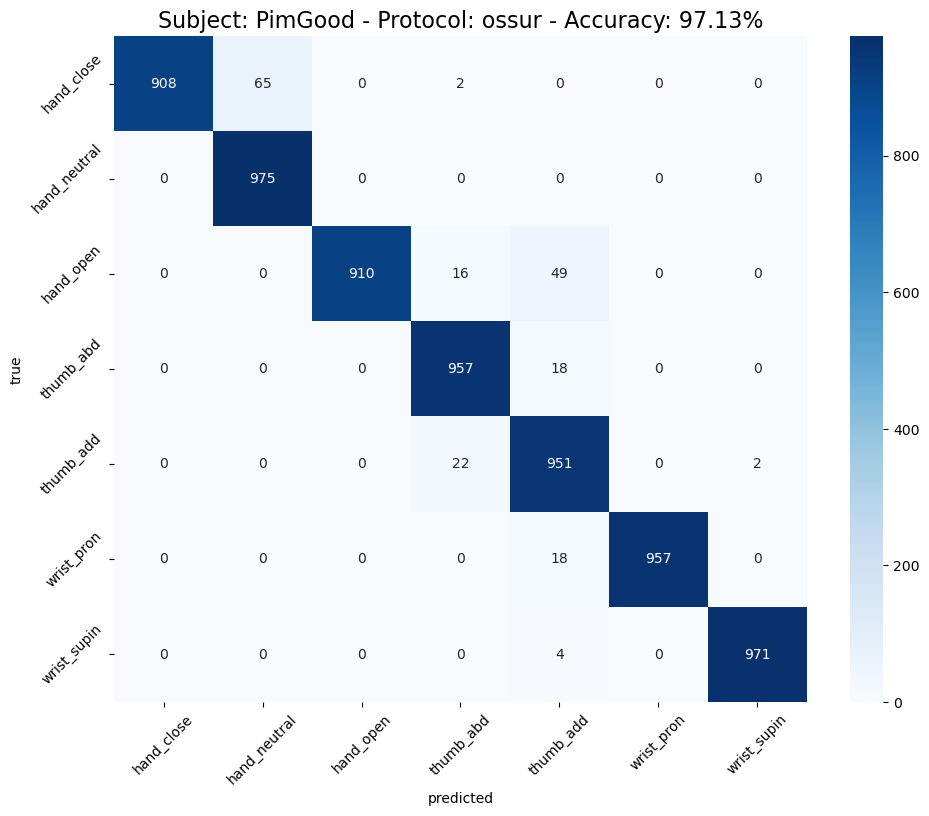

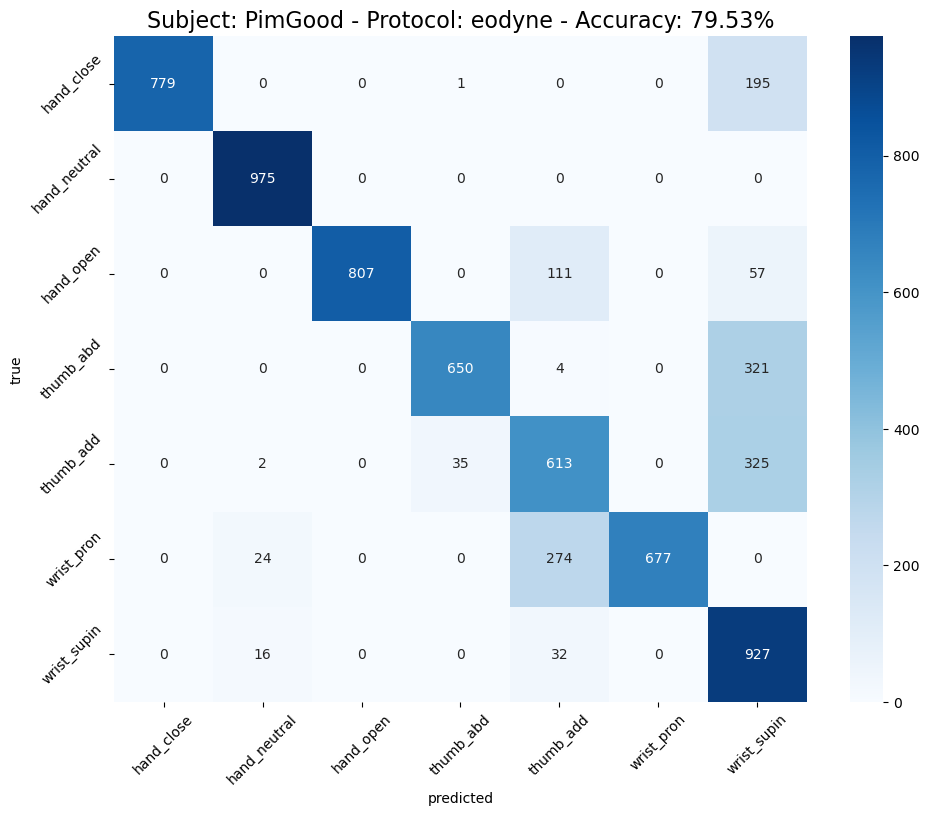

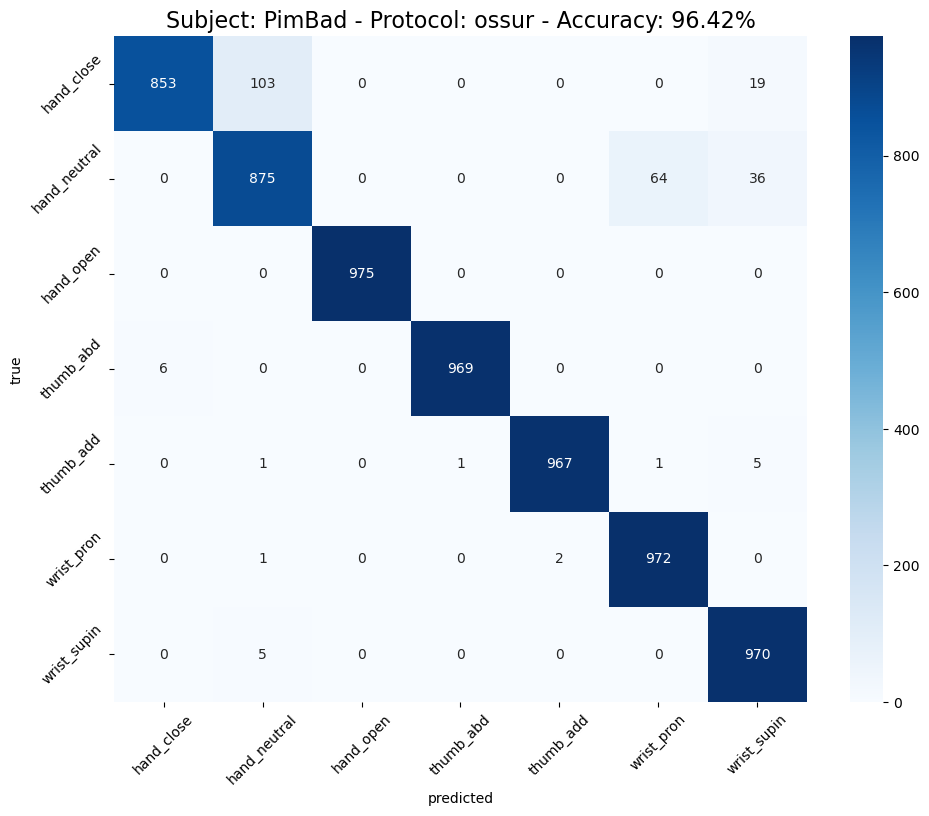

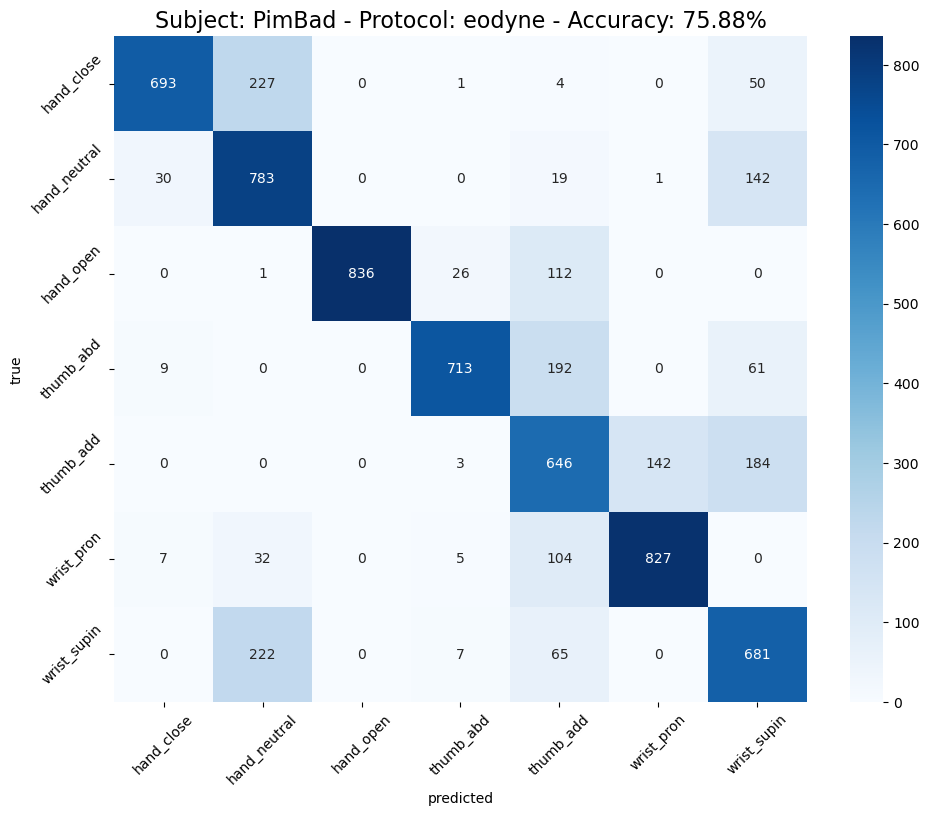

In [3]:
# for core gestures only

gestures_to_use = ["hand_close", "hand_neutral", "hand_open", 
                    "wrist_supin", "wrist_pron","thumb_abd", "thumb_add"] 


protocols = ["ossur", "eodyne"]
subjects = ["PimGood", "PimBad"]

for subject in subjects:
    files = glob(f"{data_dir}/{subject}*/*.npy")
    df = None
    for fpath in tqdm(files):

        win_fpath = PureWindowsPath(fpath)
        subject = win_fpath.parts[-2][:-1]
        take = win_fpath.parts[-2][-1]
        
        gesture = win_fpath.stem[:-20]
        timestamp = win_fpath.stem[-19:]
        
        emg, disp = parse_ossur_sensor_recording(fpath)
        emg = Signal(signal = emg, window_size=window_size, step=step_size)

        emg_features = emg.get_features()
        disp_features = resample(disp, emg_features.shape[0])
        features = np.concatenate([emg_features, disp_features], axis=1)

        if df is None:
            columns = []
            for feat in emg.features.keys():
                columns.extend([f"{feat}_{idx}" for idx in range(4)])
            
            columns.extend(["disp1","disp2", "disp3", "disp4", "gesture", "subject", "take"])
            df=pd.DataFrame(columns=columns)
        
        temp_df = pd.DataFrame(features, columns = columns[:-3])
        temp_df["gesture"] = [gesture]*temp_df.shape[0]

        
        temp_df["timestamp"] = [timestamp]*temp_df.shape[0]

        temp_df["subject"] = [subject]*temp_df.shape[0]
        temp_df["take"] = [take]*temp_df.shape[0]

        df = pd.concat([df, temp_df], ignore_index=True)

    ds= GestureRecognitionDataset(data_dir)
    df = ds.timestamp_to_iter(df)
    for protocol in protocols:
        accuracies = []
        preds = []
        ys=[]
        df = df[df.gesture.isin(gestures_to_use)]
        gestures = df.gesture.unique()
        gesture_to_int = {gesture:i for i, gesture in enumerate(gestures)}
        int_to_gesture = {val:key for key, val in gesture_to_int.items()}

        if protocol == "ossur":
            for i in range(1,6):
                df_train = df[df["iteration"] != i]
                df_test = df[df["iteration"] == i]
                model = GestureRecognitionModel()
                features_to_keep = df_train.columns[:-4]
                X_train, y_train = df_train[features_to_keep], [gesture_to_int[gesture] for gesture in df_train.gesture]
                X_test, y_test = df_test[features_to_keep], [gesture_to_int[gesture] for gesture in df_test.gesture]
                rus = RandomUnderSampler()
                X_test, y_test = rus.fit_resample(X_test, y_test)
                model.train(X_train, y_train)
                accuracies.append(model.evaluate(X_test, y_test))
                preds.extend(model.predict(X_test))
                ys.extend(y_test)


        if protocol == "eodyne":
            for i in range(1,4):
                df_train = df[df["take"] != str(i)]
                df_test = df[df["take"] == str(i)]
                model = GestureRecognitionModel()
                features_to_keep = df_train.columns[:-4]
                X_train, y_train = df_train[features_to_keep], [gesture_to_int[gesture] for gesture in df_train.gesture]
                X_test, y_test = df_test[features_to_keep], [gesture_to_int[gesture] for gesture in df_test.gesture]
                rus = RandomUnderSampler()
                X_test, y_test = rus.fit_resample(X_test, y_test)
                model.train(X_train, y_train)
                accuracies.append(model.evaluate(X_test, y_test))
                preds.extend(model.predict(X_test))
                ys.extend(y_test)

        cf_matrix = confusion_matrix(ys, preds)
        fig = plt.figure(figsize = (10, 8))
        sns.heatmap(cf_matrix, cmap='Blues', annot=True, fmt=".0f")
        plt.yticks(np.arange(0.5,len(int_to_gesture), 1), [int_to_gesture[i] for i in range(len(int_to_gesture))], rotation=45)
        plt.xticks(np.arange(0.5,len(int_to_gesture), 1), [int_to_gesture[i] for i in range(len(int_to_gesture))], rotation=45)
        plt.ylabel("true")
        plt.xlabel("predicted")
        plt.tight_layout()
        plt.title(f"Subject: {subject} - Protocol: {protocol} - Accuracy: {np.mean(accuracies)*100:.2f}%", fontdict={'fontsize': 16, 'fontweight': 'medium'})

  0%|          | 0/180 [00:00<?, ?it/s]

  0%|          | 0/183 [00:00<?, ?it/s]

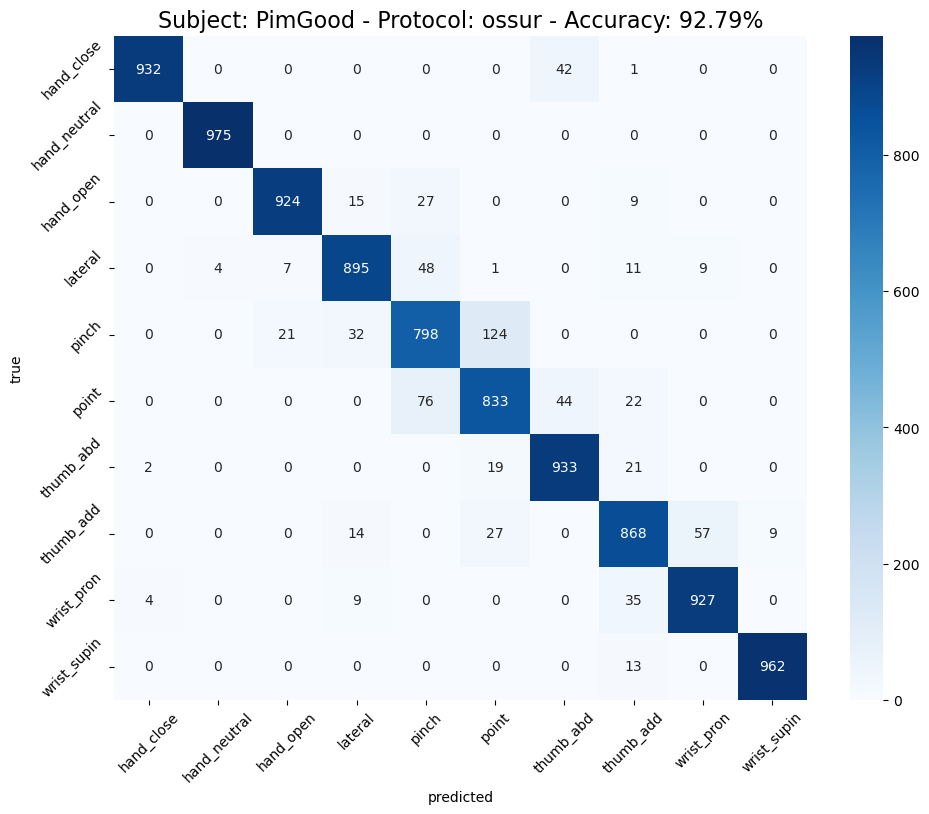

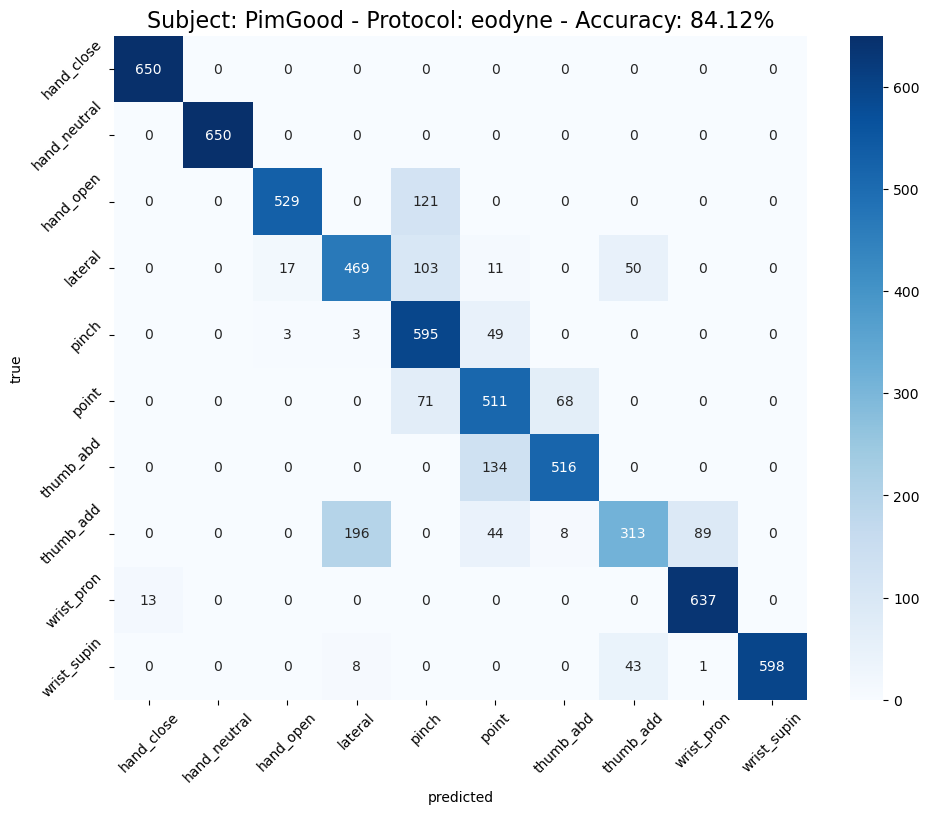

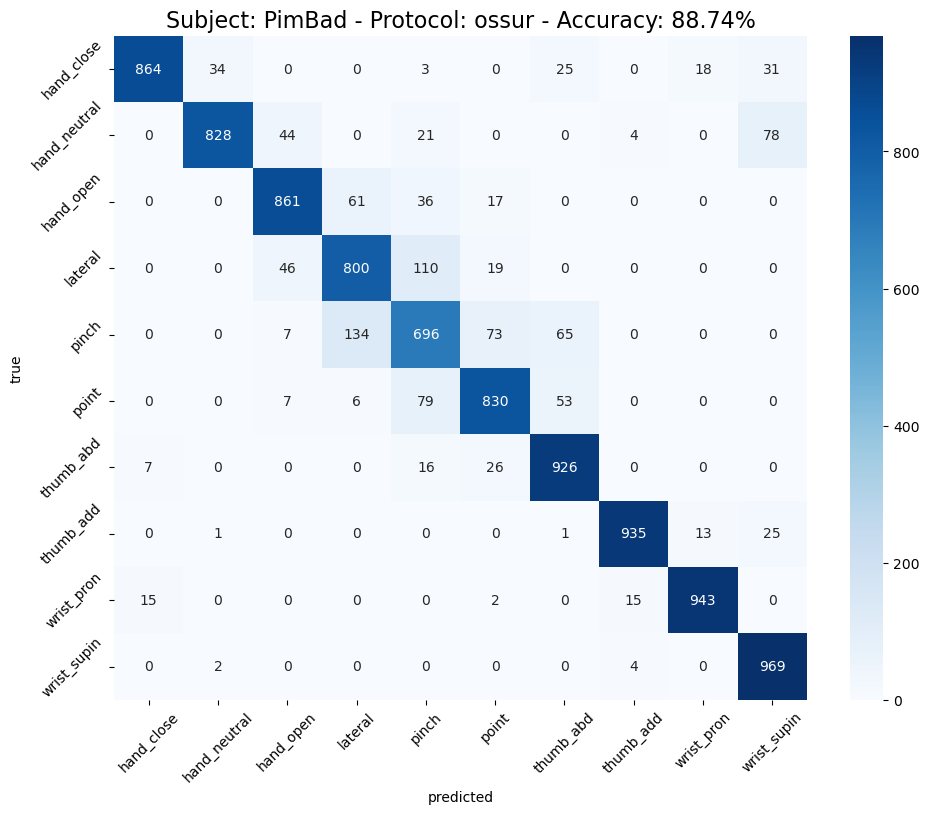

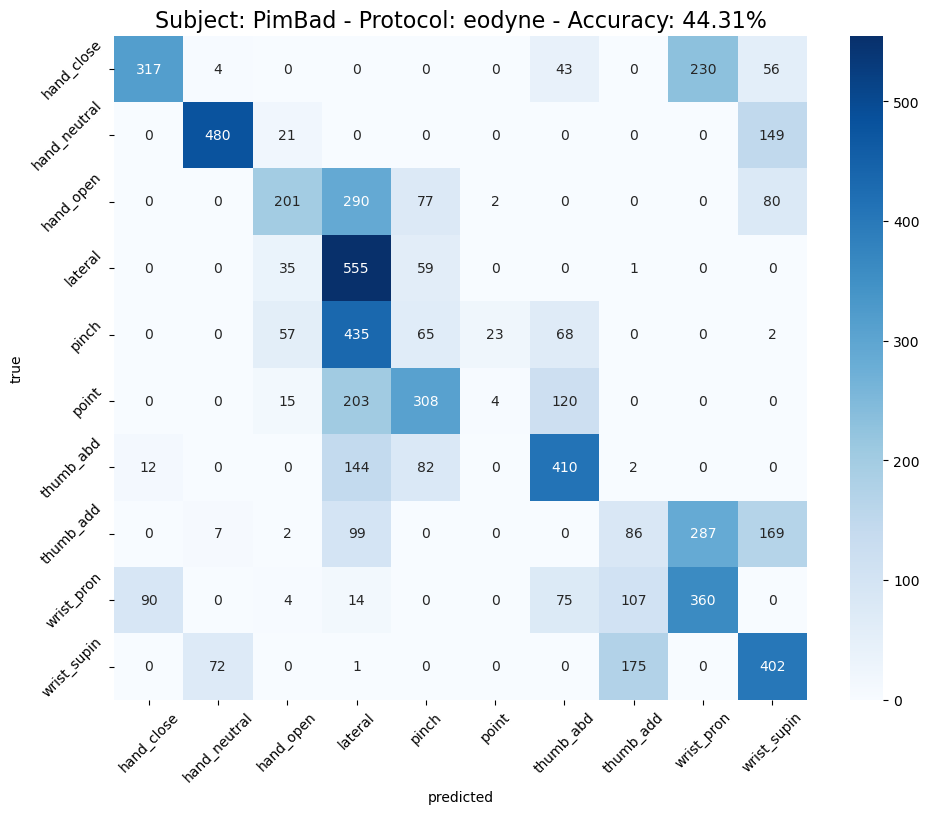

In [8]:
# EMG signals only

# for core gestures only

data_dir = "C:/Users/fents/Documents/data_experiment"

gestures_to_use = ["hand_close", "hand_neutral", "hand_open", 
                    "wrist_supin", "wrist_pron","thumb_abd", "thumb_add", "pinch", "lateral", "point"] 


protocols = ["ossur", "eodyne"]
subjects = ["PimGood", "PimBad"]

for subject in subjects:
    files = glob(f"{data_dir}/{subject}*/*.npy")
    df = None
    for fpath in tqdm(files):

        win_fpath = PureWindowsPath(fpath)
        subject = win_fpath.parts[-2][:-1]
        take = win_fpath.parts[-2][-1]
        
        gesture = win_fpath.stem[:-20]
        timestamp = win_fpath.stem[-19:]
        
        emg, disp = parse_ossur_sensor_recording(fpath)
        emg = Signal(signal = emg, window_size=window_size, step=step_size)

        emg_features = emg.get_features()
        disp_features = resample(disp, emg_features.shape[0])
        features = np.concatenate([emg_features, disp_features], axis=1)

        if df is None:
            columns = []
            for feat in emg.features.keys():
                columns.extend([f"{feat}_{idx}" for idx in range(4)])
            
            columns.extend(["disp1","disp2", "disp3", "disp4", "gesture", "subject", "take"])
            df=pd.DataFrame(columns=columns)
        
        temp_df = pd.DataFrame(features, columns = columns[:-3])
        temp_df["gesture"] = [gesture]*temp_df.shape[0]

        
        temp_df["timestamp"] = [timestamp]*temp_df.shape[0]

        temp_df["subject"] = [subject]*temp_df.shape[0]
        temp_df["take"] = [take]*temp_df.shape[0]

        df = pd.concat([df, temp_df], ignore_index=True)

    ds= GestureRecognitionDataset(data_dir)
    df = ds.timestamp_to_iter(df)
    for protocol in protocols:
        accuracies = []
        preds = []
        ys=[]
        df = df[df.gesture.isin(gestures_to_use)]
        gestures = df.gesture.unique()
        gesture_to_int = {gesture:i for i, gesture in enumerate(gestures)}
        int_to_gesture = {val:key for key, val in gesture_to_int.items()}

        if protocol == "ossur":
            for i in range(1,6):
                df_train = df[df["iteration"] != i]
                df_test = df[df["iteration"] == i]
                model = GestureRecognitionModel()
                features_to_keep = df_train.columns[:-8]
                X_train, y_train = df_train[features_to_keep], [gesture_to_int[gesture] for gesture in df_train.gesture]
                X_test, y_test = df_test[features_to_keep], [gesture_to_int[gesture] for gesture in df_test.gesture]
                rus = RandomUnderSampler()
                X_test, y_test = rus.fit_resample(X_test, y_test)
                model.train(X_train, y_train)
                accuracies.append(model.evaluate(X_test, y_test))
                preds.extend(model.predict(X_test))
                ys.extend(y_test)


        if protocol == "eodyne":
            for i in range(1,3):
                df_train = df[df["take"] != str(i)]
                df_test = df[df["take"] == str(i)]
                model = GestureRecognitionModel()
                features_to_keep = df_train.columns[:-8]
                X_train, y_train = df_train[features_to_keep], [gesture_to_int[gesture] for gesture in df_train.gesture]
                X_test, y_test = df_test[features_to_keep], [gesture_to_int[gesture] for gesture in df_test.gesture]
                rus = RandomUnderSampler()
                X_test, y_test = rus.fit_resample(X_test, y_test)
                model.train(X_train, y_train)
                accuracies.append(model.evaluate(X_test, y_test))
                preds.extend(model.predict(X_test))
                ys.extend(y_test)

        cf_matrix = confusion_matrix(ys, preds)
        fig = plt.figure(figsize = (10, 8))
        sns.heatmap(cf_matrix, cmap='Blues', annot=True, fmt=".0f")
        plt.yticks(np.arange(0.5,len(int_to_gesture), 1), [int_to_gesture[i] for i in range(len(int_to_gesture))], rotation=45)
        plt.xticks(np.arange(0.5,len(int_to_gesture), 1), [int_to_gesture[i] for i in range(len(int_to_gesture))], rotation=45)
        plt.ylabel("true")
        plt.xlabel("predicted")
        plt.tight_layout()
        plt.title(f"Subject: {subject} - Protocol: {protocol} - Accuracy: {np.mean(accuracies)*100:.2f}%", fontdict={'fontsize': 16, 'fontweight': 'medium'})

  0%|          | 0/180 [00:00<?, ?it/s]

  0%|          | 0/183 [00:00<?, ?it/s]

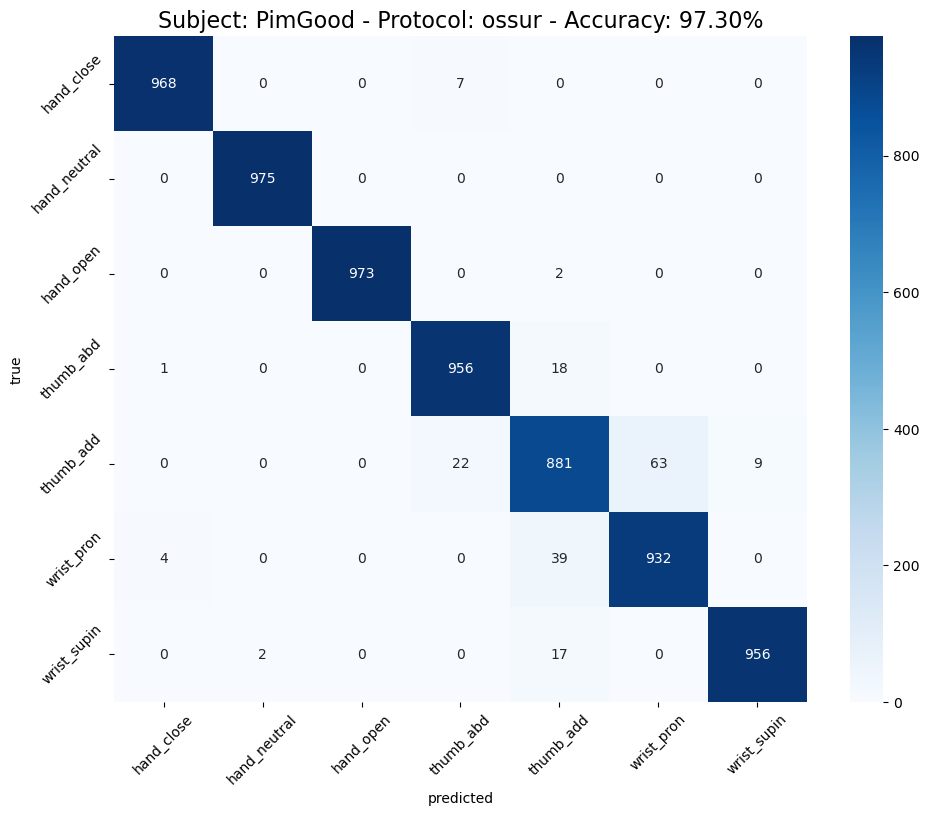

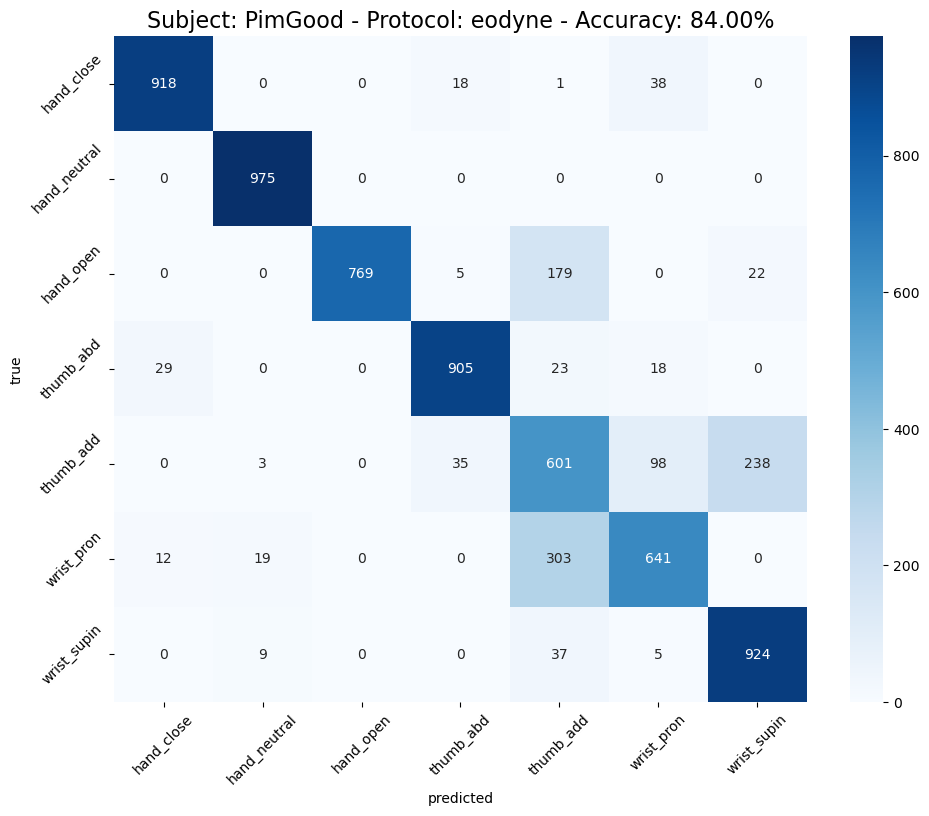

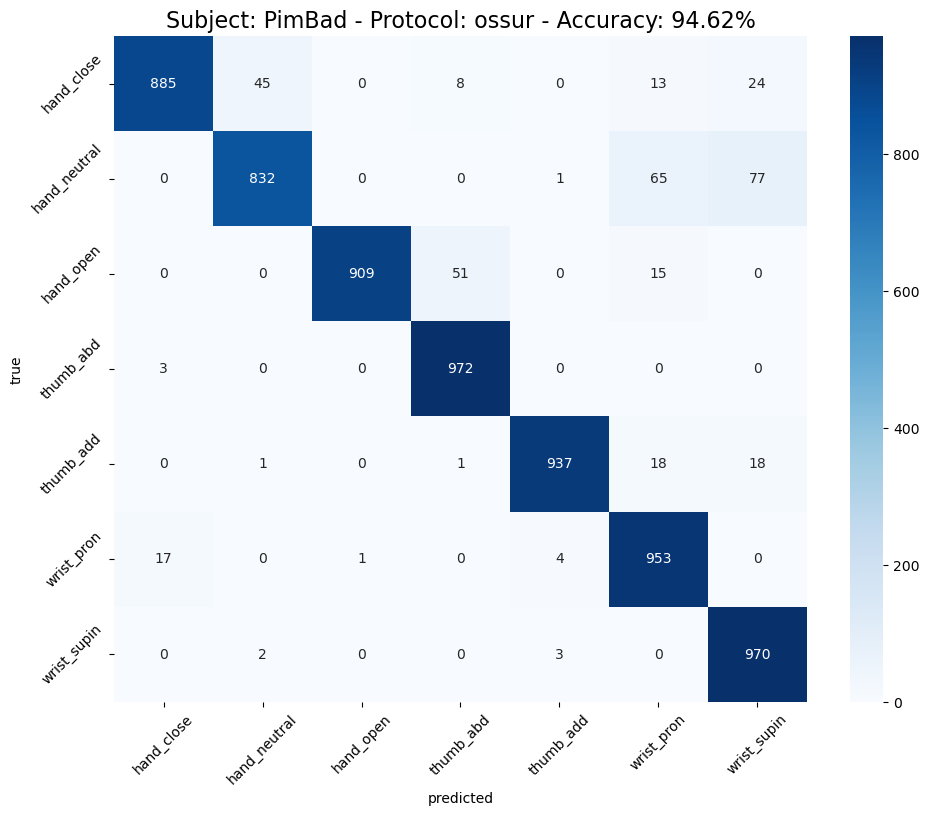

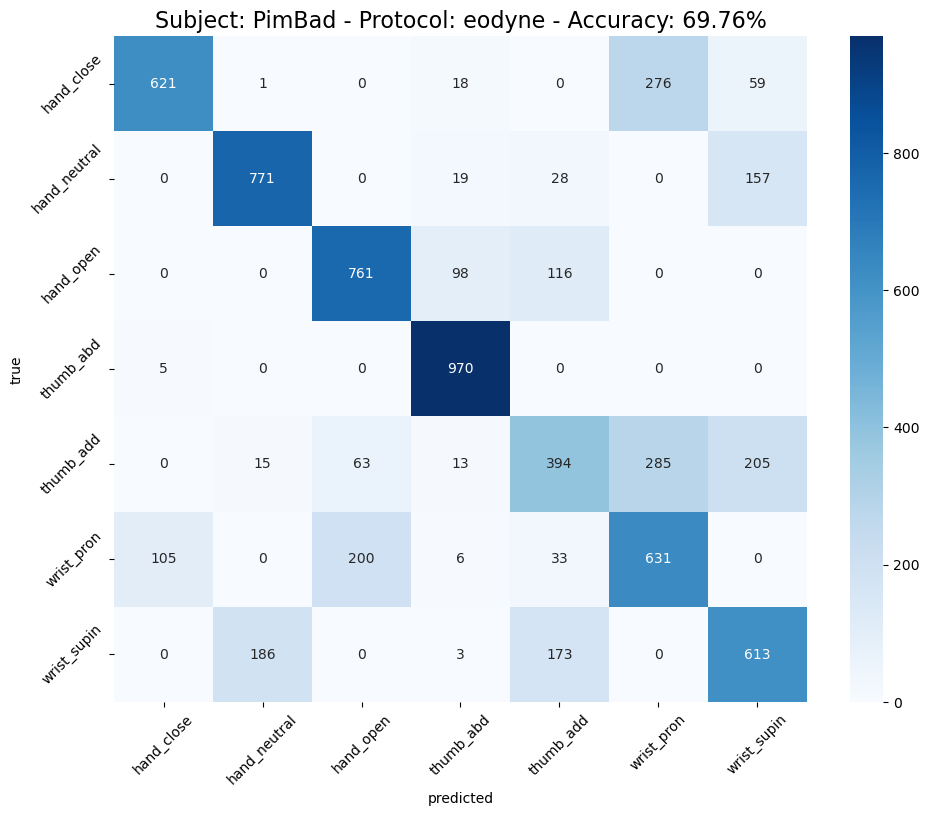

In [9]:
# for core gestures only

gestures_to_use = ["hand_close", "hand_neutral", "hand_open", 
                    "wrist_supin", "wrist_pron","thumb_abd", "thumb_add"] 


protocols = ["ossur", "eodyne"]
subjects = ["PimGood", "PimBad"]

for subject in subjects:
    files = glob(f"{data_dir}/{subject}*/*.npy")
    df = None
    for fpath in tqdm(files):

        win_fpath = PureWindowsPath(fpath)
        subject = win_fpath.parts[-2][:-1]
        take = win_fpath.parts[-2][-1]
        
        gesture = win_fpath.stem[:-20]
        timestamp = win_fpath.stem[-19:]
        
        emg, disp = parse_ossur_sensor_recording(fpath)
        emg = Signal(signal = emg, window_size=window_size, step=step_size)

        emg_features = emg.get_features()
        disp_features = resample(disp, emg_features.shape[0])
        features = np.concatenate([emg_features, disp_features], axis=1)

        if df is None:
            columns = []
            for feat in emg.features.keys():
                columns.extend([f"{feat}_{idx}" for idx in range(4)])
            
            columns.extend(["disp1","disp2", "disp3", "disp4", "gesture", "subject", "take"])
            df=pd.DataFrame(columns=columns)
        
        temp_df = pd.DataFrame(features, columns = columns[:-3])
        temp_df["gesture"] = [gesture]*temp_df.shape[0]

        
        temp_df["timestamp"] = [timestamp]*temp_df.shape[0]

        temp_df["subject"] = [subject]*temp_df.shape[0]
        temp_df["take"] = [take]*temp_df.shape[0]

        df = pd.concat([df, temp_df], ignore_index=True)

    ds= GestureRecognitionDataset(data_dir)
    df = ds.timestamp_to_iter(df)
    for protocol in protocols:
        accuracies = []
        preds = []
        ys=[]
        df = df[df.gesture.isin(gestures_to_use)]
        gestures = df.gesture.unique()
        gesture_to_int = {gesture:i for i, gesture in enumerate(gestures)}
        int_to_gesture = {val:key for key, val in gesture_to_int.items()}

        if protocol == "ossur":
            for i in range(1,6):
                df_train = df[df["iteration"] != i]
                df_test = df[df["iteration"] == i]
                model = GestureRecognitionModel()
                features_to_keep = df_train.columns[:-8]
                X_train, y_train = df_train[features_to_keep], [gesture_to_int[gesture] for gesture in df_train.gesture]
                X_test, y_test = df_test[features_to_keep], [gesture_to_int[gesture] for gesture in df_test.gesture]
                rus = RandomUnderSampler()
                X_test, y_test = rus.fit_resample(X_test, y_test)
                model.train(X_train, y_train)
                accuracies.append(model.evaluate(X_test, y_test))
                preds.extend(model.predict(X_test))
                ys.extend(y_test)


        if protocol == "eodyne":
            for i in range(1,4):
                df_train = df[df["take"] != str(i)]
                df_test = df[df["take"] == str(i)]
                model = GestureRecognitionModel()
                features_to_keep = df_train.columns[:-8]
                X_train, y_train = df_train[features_to_keep], [gesture_to_int[gesture] for gesture in df_train.gesture]
                X_test, y_test = df_test[features_to_keep], [gesture_to_int[gesture] for gesture in df_test.gesture]
                rus = RandomUnderSampler()
                X_test, y_test = rus.fit_resample(X_test, y_test)
                model.train(X_train, y_train)
                accuracies.append(model.evaluate(X_test, y_test))
                preds.extend(model.predict(X_test))
                ys.extend(y_test)

        cf_matrix = confusion_matrix(ys, preds)
        fig = plt.figure(figsize = (10, 8))
        sns.heatmap(cf_matrix, cmap='Blues', annot=True, fmt=".0f")
        plt.yticks(np.arange(0.5,len(int_to_gesture), 1), [int_to_gesture[i] for i in range(len(int_to_gesture))], rotation=45)
        plt.xticks(np.arange(0.5,len(int_to_gesture), 1), [int_to_gesture[i] for i in range(len(int_to_gesture))], rotation=45)
        plt.ylabel("true")
        plt.xlabel("predicted")
        plt.tight_layout()
        plt.title(f"Subject: {subject} - Protocol: {protocol} - Accuracy: {np.mean(accuracies)*100:.2f}%", fontdict={'fontsize': 16, 'fontweight': 'medium'})

  0%|          | 0/180 [00:00<?, ?it/s]

  0%|          | 0/183 [00:00<?, ?it/s]

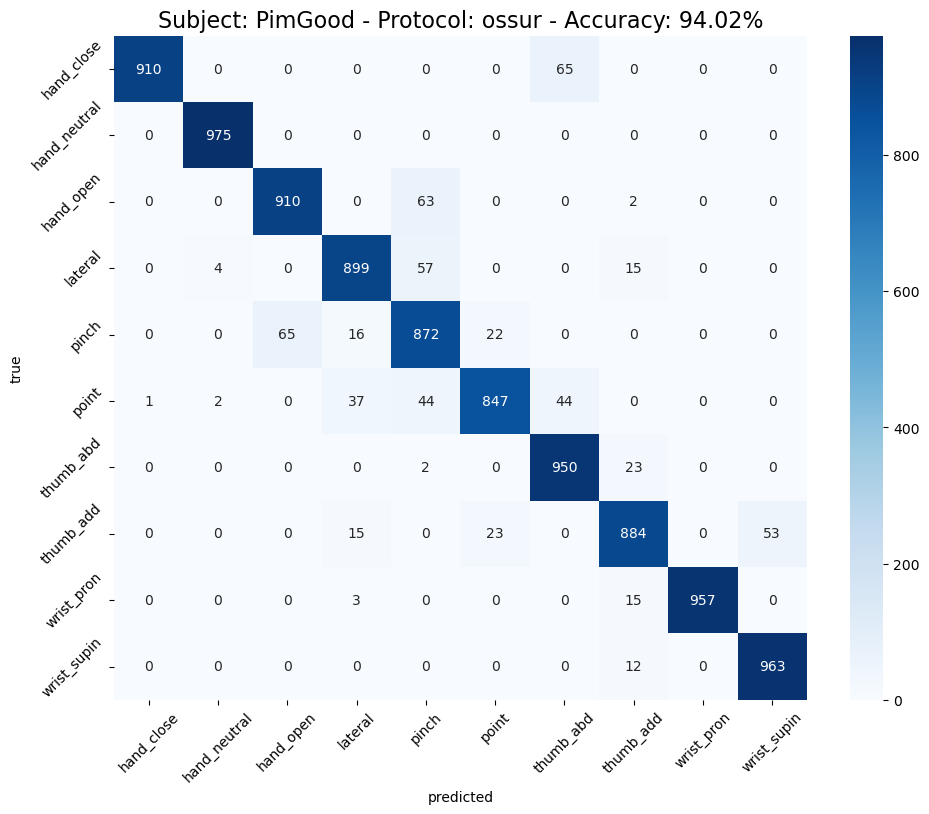

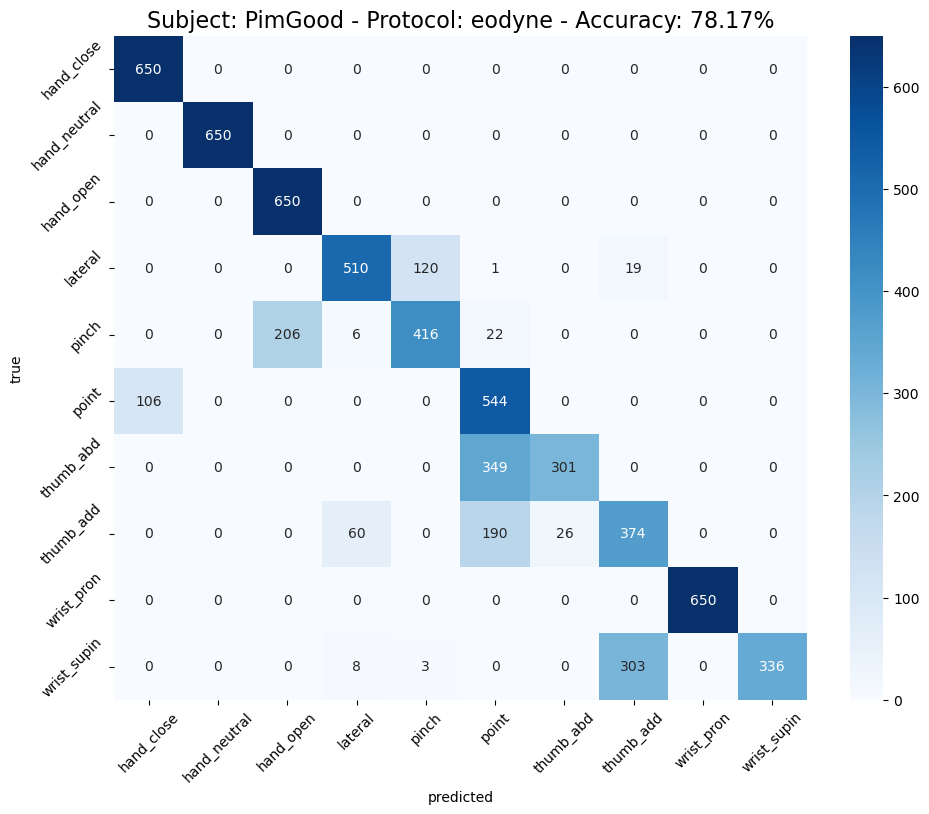

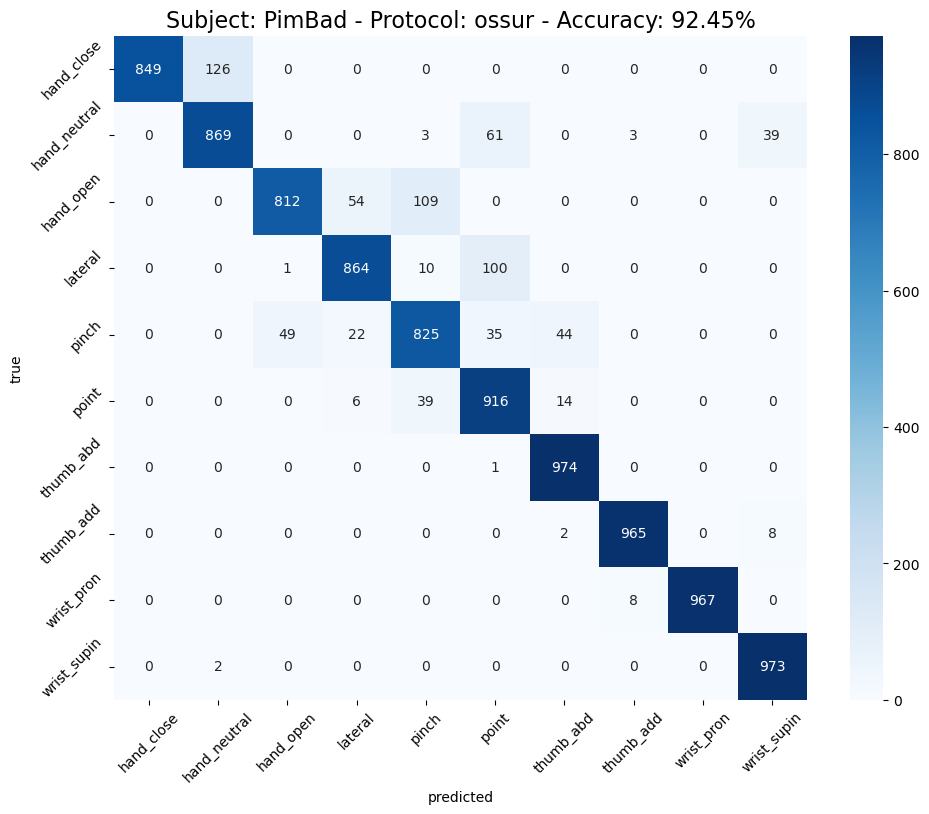

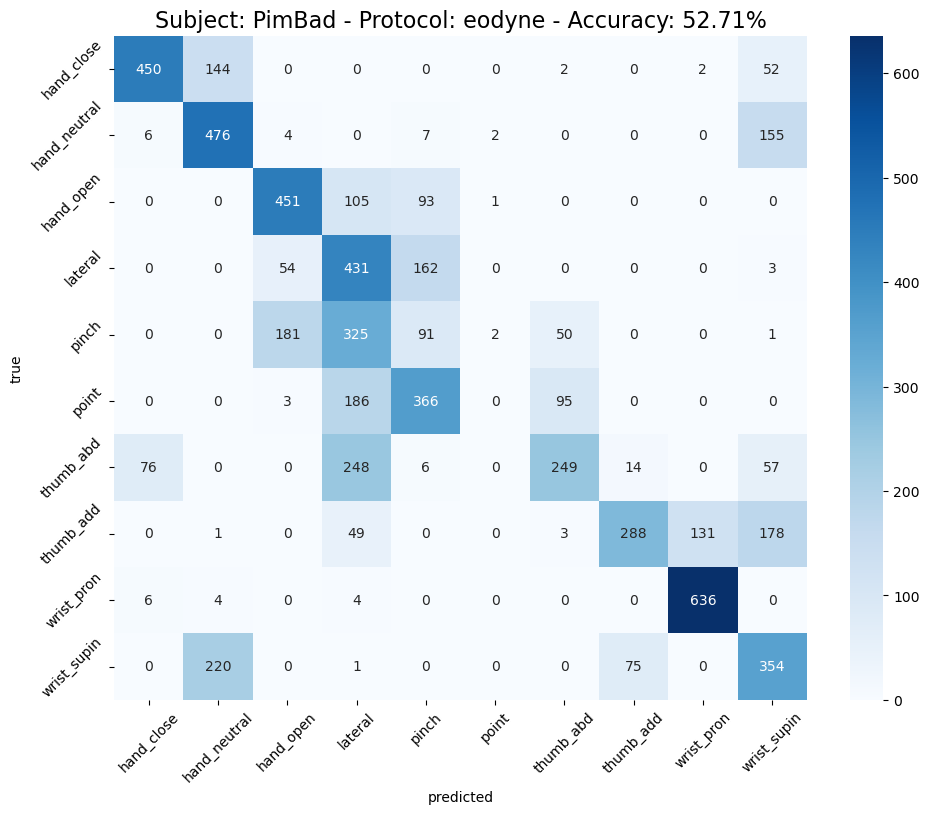

In [22]:
# try with normalisation

data_dir = "C:/Users/fents/Documents/data_experiment"

gestures_to_use = ["hand_close", "hand_neutral", "hand_open", 
                    "wrist_supin", "wrist_pron","thumb_abd", "thumb_add", "pinch", "lateral", "point"] 


protocols = ["ossur", "eodyne"]
subjects = ["PimGood", "PimBad"]

for subject in subjects:
    files = glob(f"{data_dir}/{subject}*/*.npy")
    df = None
    for fpath in tqdm(files):

        win_fpath = PureWindowsPath(fpath)
        subject = win_fpath.parts[-2][:-1]
        take = win_fpath.parts[-2][-1]
        
        gesture = win_fpath.stem[:-20]
        timestamp = win_fpath.stem[-19:]
        
        emg, disp = parse_ossur_sensor_recording(fpath)
        emg = Signal(signal = emg, window_size=window_size, step=step_size)

        emg_features = emg.get_features()
        disp_features = resample(disp, emg_features.shape[0])
        features = np.concatenate([emg_features, disp_features], axis=1)

        if df is None:
            columns = []
            for feat in emg.features.keys():
                columns.extend([f"{feat}_{idx}" for idx in range(4)])
            
            columns.extend(["disp1","disp2", "disp3", "disp4", "gesture", "subject", "take"])
            df=pd.DataFrame(columns=columns)
        
        temp_df = pd.DataFrame(features, columns = columns[:-3])
        temp_df["gesture"] = [gesture]*temp_df.shape[0]

        
        temp_df["timestamp"] = [timestamp]*temp_df.shape[0]

        temp_df["subject"] = [subject]*temp_df.shape[0]
        temp_df["take"] = [take]*temp_df.shape[0]

        df = pd.concat([df, temp_df], ignore_index=True)

    ds= GestureRecognitionDataset(data_dir)
    df = ds.timestamp_to_iter(df)

    df_neutral = df[df["gesture"] == "hand_neutral"]
    average_disp2 = df_neutral["disp2"].mean()
    average_disp4 = df_neutral["disp4"].mean()

    df["disp2"] -= average_disp2
    df["disp4"] -= average_disp4

    for protocol in protocols:
        accuracies = []
        preds = []
        ys=[]
        df = df[df.gesture.isin(gestures_to_use)]
        gestures = df.gesture.unique()
        gesture_to_int = {gesture:i for i, gesture in enumerate(gestures)}
        int_to_gesture = {val:key for key, val in gesture_to_int.items()}

        if protocol == "ossur":
            for i in range(1,6):
                df_train = df[df["iteration"] != i]
                df_test = df[df["iteration"] == i]
                model = GestureRecognitionModel()
                features_to_keep = df_train.columns[:-4]
                X_train, y_train = df_train[features_to_keep], [gesture_to_int[gesture] for gesture in df_train.gesture]
                X_test, y_test = df_test[features_to_keep], [gesture_to_int[gesture] for gesture in df_test.gesture]
                rus = RandomUnderSampler()
                X_test, y_test = rus.fit_resample(X_test, y_test)
                model.train(X_train, y_train)
                accuracies.append(model.evaluate(X_test, y_test))
                preds.extend(model.predict(X_test))
                ys.extend(y_test)


        if protocol == "eodyne":
            for i in range(1,3):
                df_train = df[df["take"] != str(i)]
                df_test = df[df["take"] == str(i)]
                model = GestureRecognitionModel()
                features_to_keep = df_train.columns[:-4]
                X_train, y_train = df_train[features_to_keep], [gesture_to_int[gesture] for gesture in df_train.gesture]
                X_test, y_test = df_test[features_to_keep], [gesture_to_int[gesture] for gesture in df_test.gesture]
                rus = RandomUnderSampler()
                X_test, y_test = rus.fit_resample(X_test, y_test)
                model.train(X_train, y_train)
                accuracies.append(model.evaluate(X_test, y_test))
                preds.extend(model.predict(X_test))
                ys.extend(y_test)

        cf_matrix = confusion_matrix(ys, preds)
        fig = plt.figure(figsize = (10, 8))
        sns.heatmap(cf_matrix, cmap='Blues', annot=True, fmt=".0f")
        plt.yticks(np.arange(0.5,len(int_to_gesture), 1), [int_to_gesture[i] for i in range(len(int_to_gesture))], rotation=45)
        plt.xticks(np.arange(0.5,len(int_to_gesture), 1), [int_to_gesture[i] for i in range(len(int_to_gesture))], rotation=45)
        plt.ylabel("true")
        plt.xlabel("predicted")
        plt.tight_layout()
        plt.title(f"Subject: {subject} - Protocol: {protocol} - Accuracy: {np.mean(accuracies)*100:.2f}%", fontdict={'fontsize': 16, 'fontweight': 'medium'})



  0%|          | 0/180 [00:00<?, ?it/s]

  0%|          | 0/183 [00:00<?, ?it/s]

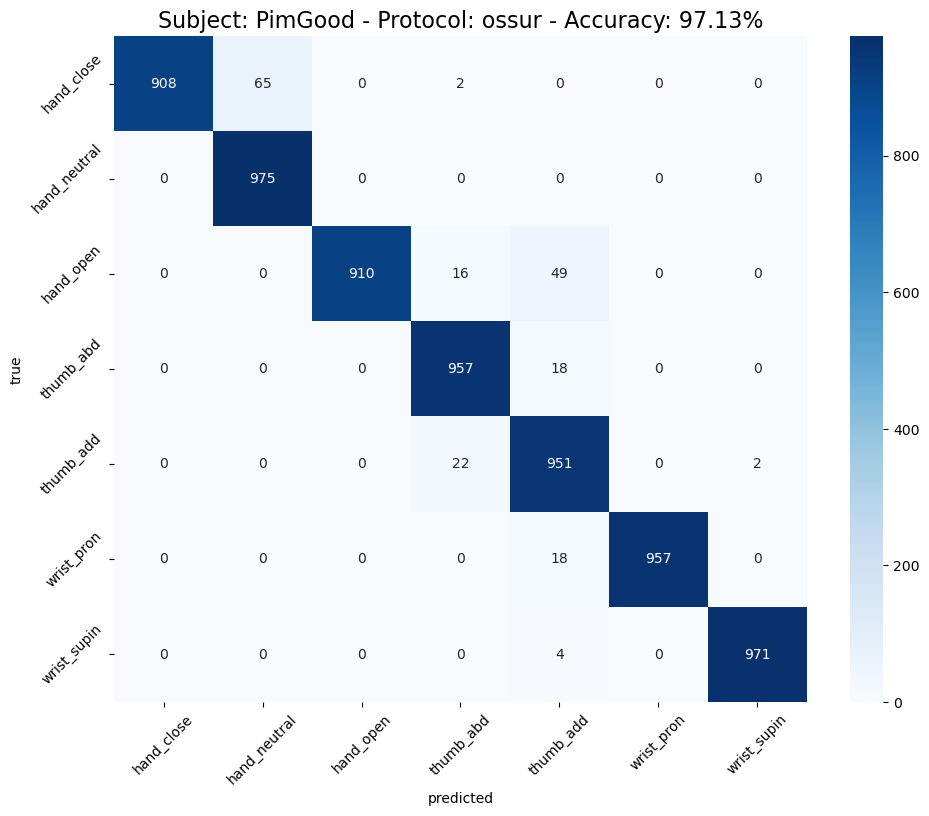

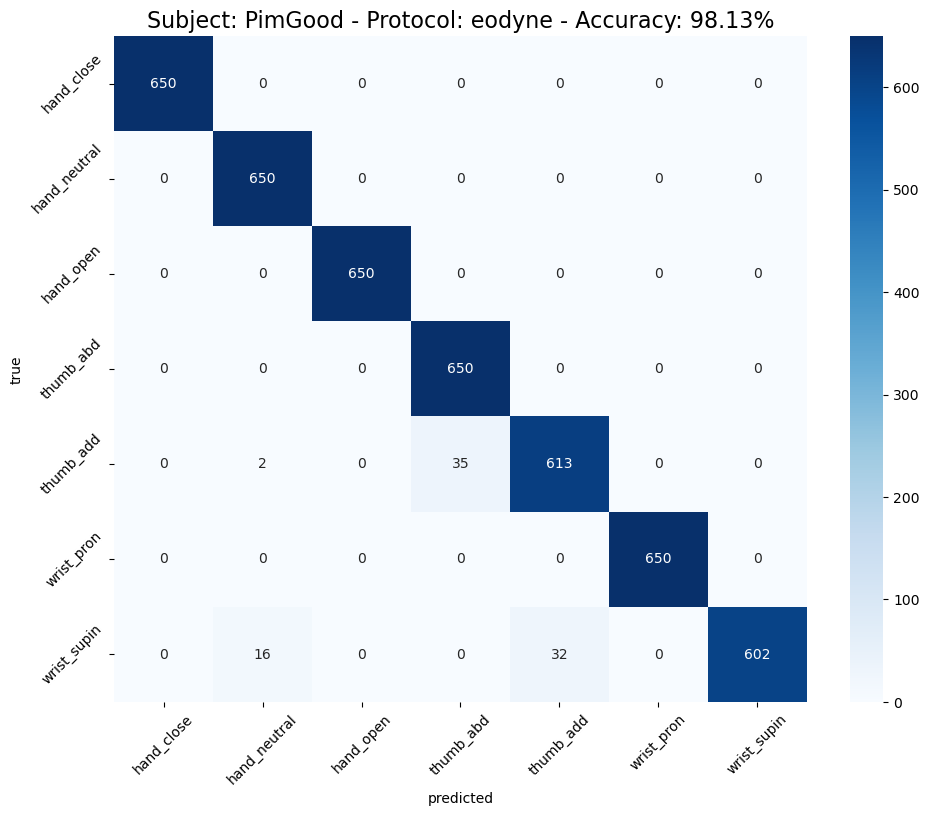

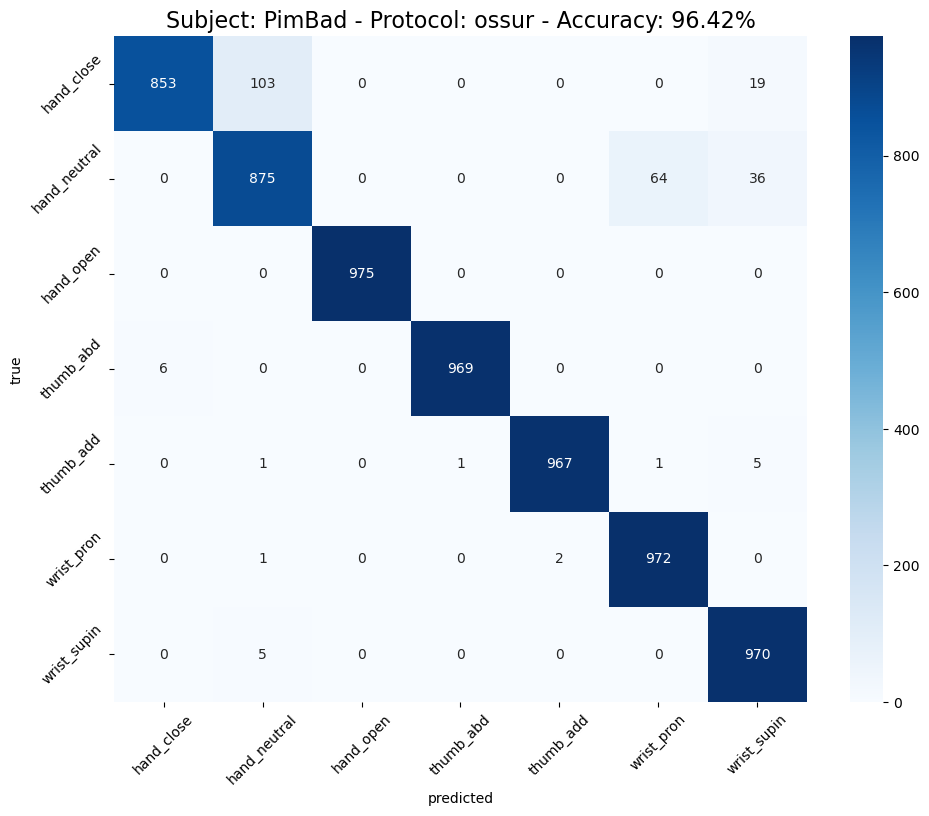

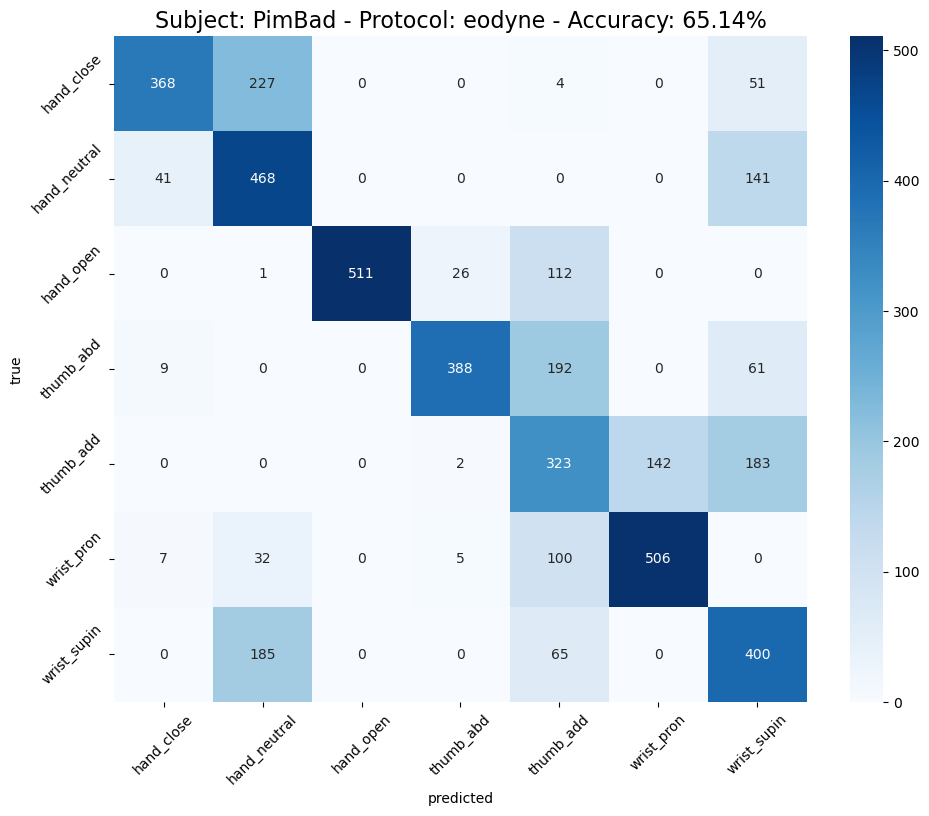

In [23]:
gestures_to_use = ["hand_close", "hand_neutral", "hand_open", 
                    "wrist_supin", "wrist_pron","thumb_abd", "thumb_add"] 

# try with normalisation, core gestures only

data_dir = "C:/Users/fents/Documents/data_experiment"

protocols = ["ossur", "eodyne"]
subjects = ["PimGood", "PimBad"]

for subject in subjects:
    files = glob(f"{data_dir}/{subject}*/*.npy")
    df = None
    for fpath in tqdm(files):

        win_fpath = PureWindowsPath(fpath)
        subject = win_fpath.parts[-2][:-1]
        take = win_fpath.parts[-2][-1]
        
        gesture = win_fpath.stem[:-20]
        timestamp = win_fpath.stem[-19:]
        
        emg, disp = parse_ossur_sensor_recording(fpath)
        emg = Signal(signal = emg, window_size=window_size, step=step_size)

        emg_features = emg.get_features()
        disp_features = resample(disp, emg_features.shape[0])
        features = np.concatenate([emg_features, disp_features], axis=1)

        if df is None:
            columns = []
            for feat in emg.features.keys():
                columns.extend([f"{feat}_{idx}" for idx in range(4)])
            
            columns.extend(["disp1","disp2", "disp3", "disp4", "gesture", "subject", "take"])
            df=pd.DataFrame(columns=columns)
        
        temp_df = pd.DataFrame(features, columns = columns[:-3])
        temp_df["gesture"] = [gesture]*temp_df.shape[0]

        
        temp_df["timestamp"] = [timestamp]*temp_df.shape[0]

        temp_df["subject"] = [subject]*temp_df.shape[0]
        temp_df["take"] = [take]*temp_df.shape[0]

        df = pd.concat([df, temp_df], ignore_index=True)

    ds= GestureRecognitionDataset(data_dir)
    df = ds.timestamp_to_iter(df)

    df_neutral = df[df["gesture"] == "hand_neutral"]
    average_disp2 = df_neutral["disp2"].mean()
    average_disp4 = df_neutral["disp4"].mean()

    df["disp2"] -= average_disp2
    df["disp4"] -= average_disp4

    for protocol in protocols:
        accuracies = []
        preds = []
        ys=[]
        df = df[df.gesture.isin(gestures_to_use)]
        gestures = df.gesture.unique()
        gesture_to_int = {gesture:i for i, gesture in enumerate(gestures)}
        int_to_gesture = {val:key for key, val in gesture_to_int.items()}

        if protocol == "ossur":
            for i in range(1,6):
                df_train = df[df["iteration"] != i]
                df_test = df[df["iteration"] == i]
                model = GestureRecognitionModel()
                features_to_keep = df_train.columns[:-4]
                X_train, y_train = df_train[features_to_keep], [gesture_to_int[gesture] for gesture in df_train.gesture]
                X_test, y_test = df_test[features_to_keep], [gesture_to_int[gesture] for gesture in df_test.gesture]
                rus = RandomUnderSampler()
                X_test, y_test = rus.fit_resample(X_test, y_test)
                model.train(X_train, y_train)
                accuracies.append(model.evaluate(X_test, y_test))
                preds.extend(model.predict(X_test))
                ys.extend(y_test)


        if protocol == "eodyne":
            for i in range(1,3):
                df_train = df[df["take"] != str(i)]
                df_test = df[df["take"] == str(i)]
                model = GestureRecognitionModel()
                features_to_keep = df_train.columns[:-4]
                X_train, y_train = df_train[features_to_keep], [gesture_to_int[gesture] for gesture in df_train.gesture]
                X_test, y_test = df_test[features_to_keep], [gesture_to_int[gesture] for gesture in df_test.gesture]
                rus = RandomUnderSampler()
                X_test, y_test = rus.fit_resample(X_test, y_test)
                model.train(X_train, y_train)
                accuracies.append(model.evaluate(X_test, y_test))
                preds.extend(model.predict(X_test))
                ys.extend(y_test)

        cf_matrix = confusion_matrix(ys, preds)
        fig = plt.figure(figsize = (10, 8))
        sns.heatmap(cf_matrix, cmap='Blues', annot=True, fmt=".0f")
        plt.yticks(np.arange(0.5,len(int_to_gesture), 1), [int_to_gesture[i] for i in range(len(int_to_gesture))], rotation=45)
        plt.xticks(np.arange(0.5,len(int_to_gesture), 1), [int_to_gesture[i] for i in range(len(int_to_gesture))], rotation=45)
        plt.ylabel("true")
        plt.xlabel("predicted")
        plt.tight_layout()
        plt.title(f"Subject: {subject} - Protocol: {protocol} - Accuracy: {np.mean(accuracies)*100:.2f}%", fontdict={'fontsize': 16, 'fontweight': 'medium'})
